# DE data analysis

I still feel the need to have a notebook storing all the data analysis. It has the following components:

- the parameter space of $OD$, $D$, $d$
- trajectory visualization and position distribution
- MSD of all curves
- extraction of $D_A$, $\tau$ and $\tau^*$ from MSD (fitting)
- $D_A$, $\tau$ and $\tau^*$ depends on $OD$, $D$ and $d$

In [227]:
from deLib import de_data
import pandas as pd
import os
import matplotlib.pyplot as plt
from myImageLib import bestcolor, gauss1, readdata
import numpy as np
from scipy.optimize import curve_fit
import trackpy as tp
from matplotlib.patches import Ellipse
from corrLib import autocorr1d
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d
from matplotlib import colors, cm

## 0 Parameter space

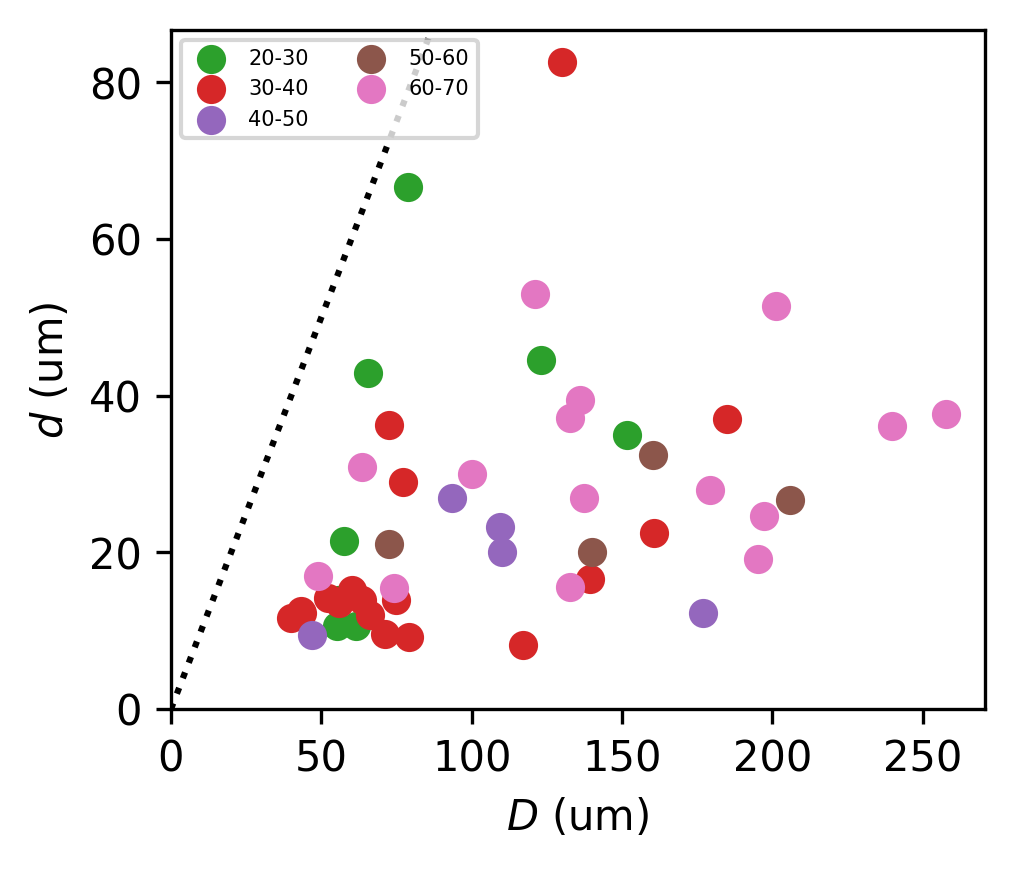

In [315]:
# load log file
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))

# filter out Chile data
log1 = log.loc[(log.Comment!="Chile")&(log.OD<80)&(log.OD>20)]
dd = de_data(log1)

dd.parameter_space()
# plt.scatter(log_new.D, log_new.d, marker="^", edgecolor=bestcolor(1), facecolor=(0,0,0,0))

## 1 Trajectory visualization and position distributions

## 2 Plot all the MSD together, rescale with $t_2$ and $D_A$ 

In [373]:
# There are trajectories that show weird MSD, 
# some of them are due to the very tiny displacement, 
# for others the reason is not yet clear
suspicious_traj = [161, 171, 172, 176, 179, 182, 185, 192, 194, 55]

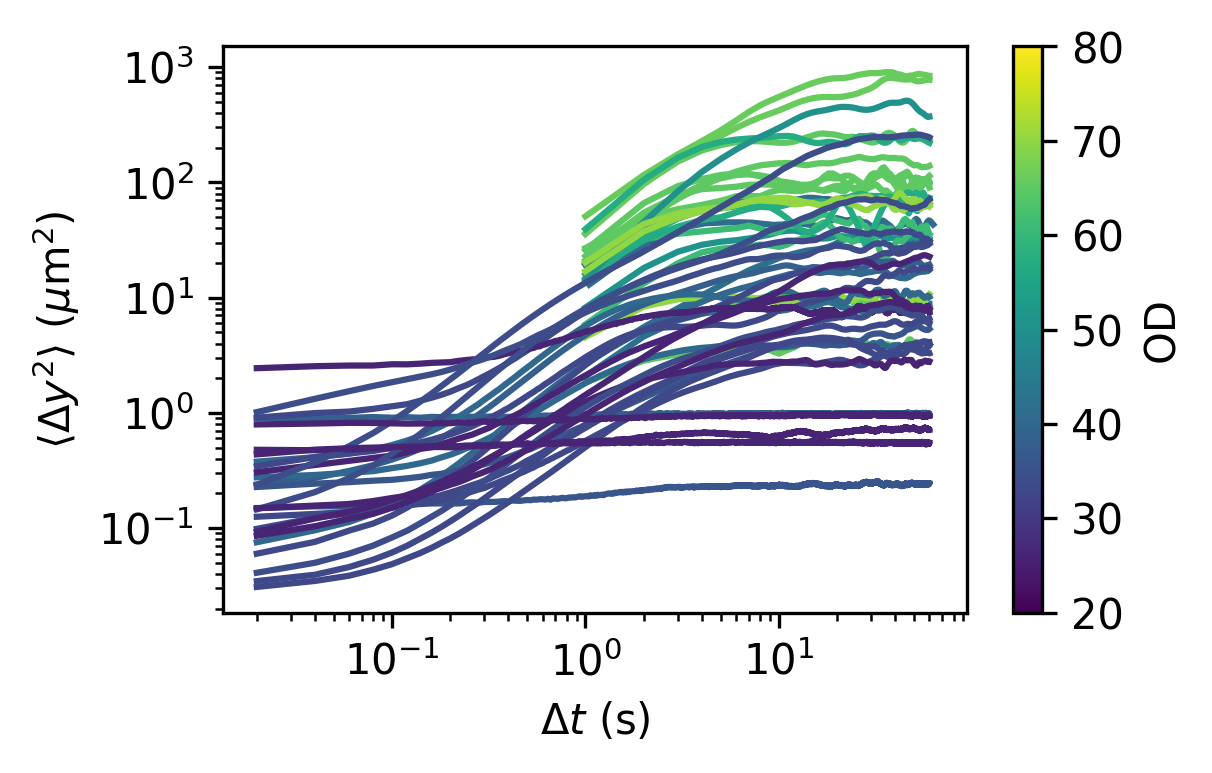

In [317]:
# load all the trajectories and compute corresponding MSDs
traj_list, msd_list = {}, {}
for num, i in log1.iterrows():
    nDE = int(i["DE#"])
    traj_list[nDE] = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(nDE)).fillna(method="ffill").fillna(method="bfill")
    msd_list[nDE] = tp.msd(traj_list[nDE], mpp=i.MPP, fps=i.FPS, max_lagtime=3000).dropna()

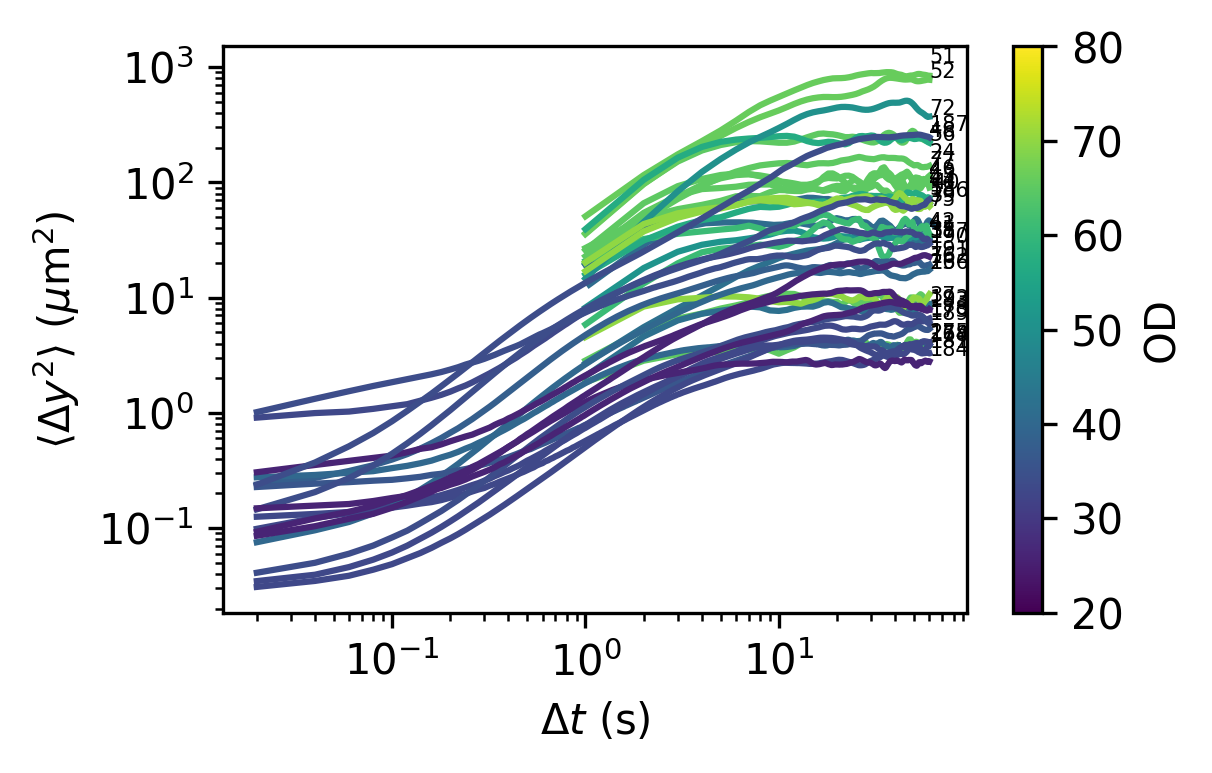

In [374]:
# plot MSD, filter out the suspicious ones
plt.figure(figsize=(4, 2.5), dpi=300)
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
for num, i in log1.iterrows():
    nDE = int(i["DE#"])
    if nDE in suspicious_traj:
        continue
    plt.plot(msd_list[nDE].lagt, msd_list[nDE]["<y^2>"], color=viridis(norm(i.OD)), label=nDE)
    plt.annotate(nDE, (msd_list[nDE].iloc[-1, 5], msd_list[nDE].iloc[-1, 4]), xycoords="data", fontsize=5)
plt.loglog()
plt.xlabel("$\Delta t$ (s)")
plt.ylabel("$\langle \Delta y^2 \\rangle$ ($\mu$m$^2$)")
sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, label="OD")

Text(0, 0.5, '$\\langle \\Delta y^2 \\rangle / D_A\\tau^*$')

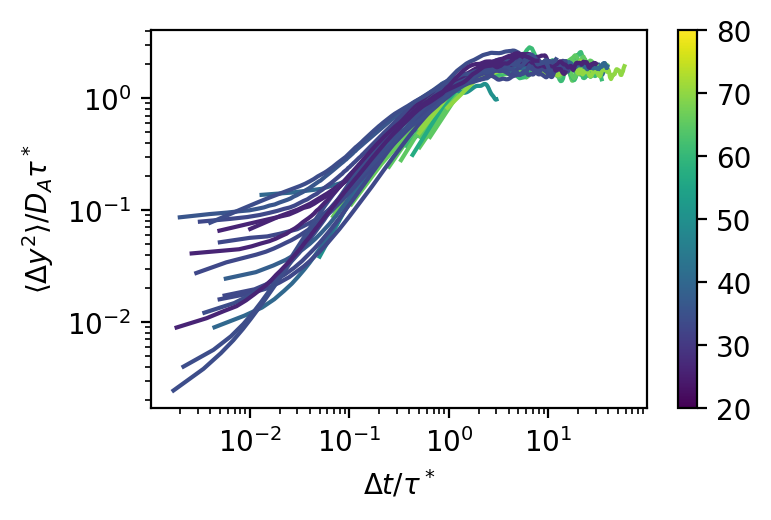

In [379]:
# plot rescaled MSD, collapse
log2 = log1.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, ax=ax)
for num, i in log2.iterrows():
    nDE = int(i["DE#"])
    if nDE in suspicious_traj:
        continue
    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    ax.plot(msd_list[nDE].lagt/t2, msd_list[nDE]["<y^2>"]/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
#     if len(msd_list[nDE]) != 0:
#         ax.annotate(nDE, 
#                      [msd_list[nDE].lagt.iloc[0]/t2, msd_list[nDE]["<y^2>"].iloc[0]/DA/t2],
#                      xycoords="data", fontsize=5)    
ax.loglog()
ax.set_xlabel("$\Delta t/\\tau^*$")
ax.set_ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")

Text(0, 0.5, '$\\langle \\Delta y^2 \\rangle / D_A\\tau^*$')

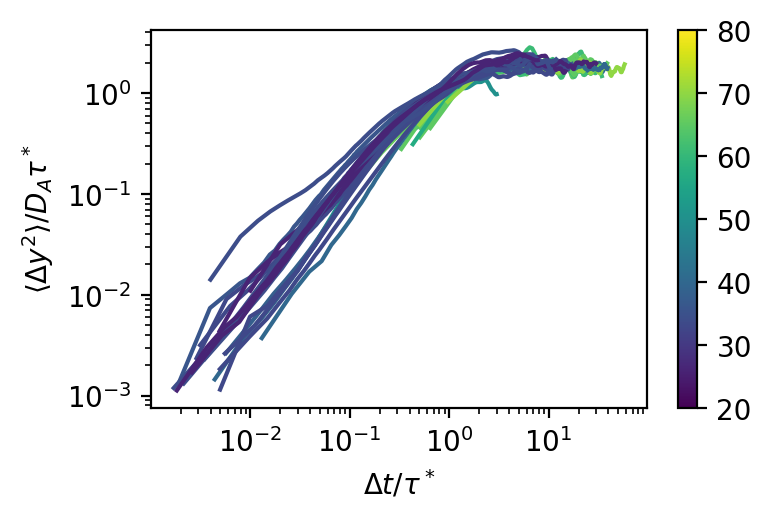

In [378]:
# plot rescaled and corrected MSD, subdiffive regime should disappear
log2 = log1.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, ax=ax)
for num, i in log2.iterrows():
    nDE = int(i["DE#"])
    if nDE in suspicious_traj:
        continue
    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    msd = msd_list[nDE]
    x = msd.lagt.iloc[:10]
    y = msd["<y^2>"].iloc[:10]
    p = np.polyfit(x, y, 2)
    xfit = np.linspace(0, 0.2)
    yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
    offset = yfit[0]
    if nDE <= 80:
        offset = 0
    ax.plot(msd.lagt/t2, (msd["<y^2>"] - offset)/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
#     if len(msd_list[nDE]) != 0:
#         ax.annotate(nDE, 
#                      [msd_list[nDE].lagt.iloc[0]/t2, msd_list[nDE]["<y^2>"].iloc[0]/DA/t2],
#                      xycoords="data", fontsize=5)    
ax.loglog()
ax.set_xlabel("$\Delta t/\\tau^*$")
ax.set_ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")

## 2 Unambiguous measurement of $R_\infty$ and $\tau^*$

Previously, I use hand fitting to roughly measure the saturation time $\tau^*$ and displacement $R_\infty$ of inner droplet MSD. While this technique allow quick data extraction, the measurement is ambiguous and inaccurate for a careful data analysis. Therefore, I now use real curve fitting to extract these values. I use the formula from Maggi et al. 2014 for the first test
$$
\left< \Delta y^2(t) \right> = \frac{2D_A}{\mu k} \frac{1-e^{-\mu kt} - \mu k\tau(1-e^{-t/\tau})}{1-(\mu k\tau)^2}
$$
To make the two time scales more apparent, let $\mu k = 1/\tau^*$ :
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

### 2.0 Preprocessing of MSD data

In the past, we have tried to smooth the trajectory data and then compute MSD. While this approach can successfully eliminate the subdiffusive regime in the MSD, it always creates an artificial ballistic regime. Even worse, if the smooth window size is not chosen properly, the artificial time scale can overwrite the time scale from the measurement, making the measurement meaningless.

Hence, we seek a threoretical approach based on reasonable assumptions to minimize the impact of detection noise, while keeping other key features unchanged.

Briefly, if we assume the detection noise of droplets $\sigma$ to be random and uncorrelated in time, i.e.
$$
\left< \sigma \right> = 0, \, \left< \sigma_i\sigma_j \right> = A\delta_{ij},
$$
the effect of noise $\sigma$ on the mean square displacement is just a constant offset:
$$
\left< \Delta y^2 \right> = \left<\Delta x^2\right> + 2A
$$

We can evaluate this equation at $\Delta t = 0$, where $\Delta x^2 = 0$ is true, to get the value of $A$:
$$
2A = \left< \Delta y^2 \right>_{\Delta t=0}
$$

For full details, refer to the note [Deal with detection noise](../Notes/2022-07-21_deal-with-detection-noise.pdf) 

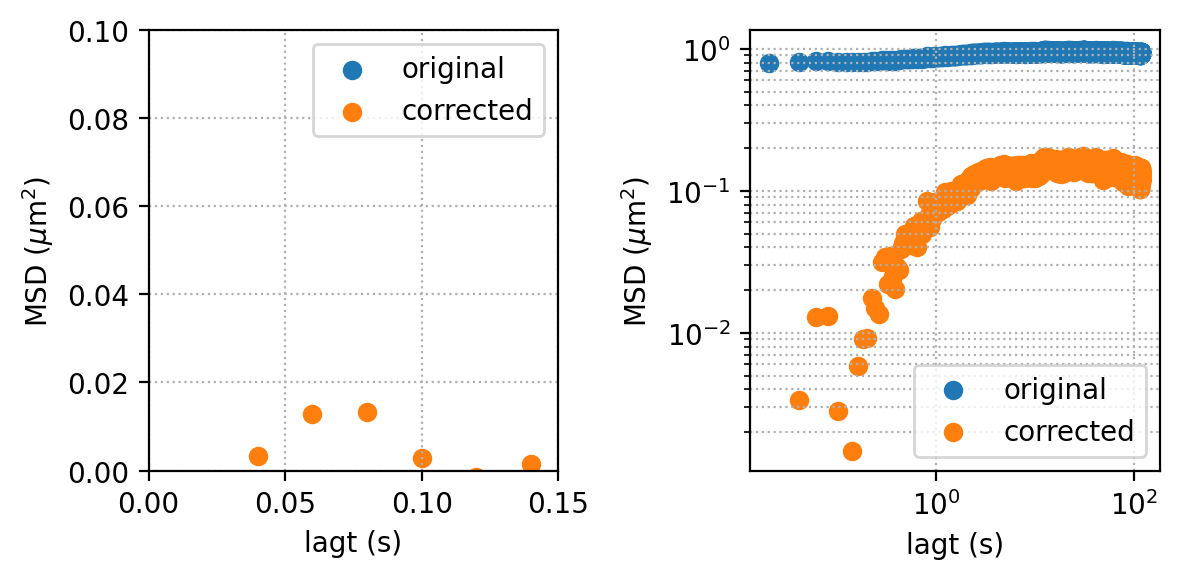

In [371]:
# load data
i = 194
logi = log.loc[log["DE#"]==i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# compute MSD
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
msd = msd.dropna()
# determine offset using extrapolation
x = msd.lagt.iloc[:10]
y = msd["<y^2>"].iloc[:10]
p = np.polyfit(x, y, 2)
xfit = np.linspace(0, 0.2)
yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
offset = yfit[0]
# create new_msd
new_msd = msd.copy()
new_msd["<y^2>"] -= offset

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

# Extrapolate offset visualization
ax[0].scatter(x, y, label="original")
ax[0].plot(xfit, yfit, color="red")
ax[0].scatter(xfit[0], yfit[0], marker="x", color="red", s=100)
ax[0].scatter(x, y-offset, label="corrected")
ax[0].set_xlabel("lagt (s)")
ax[0].set_ylabel("MSD ($\mu$m$^2$)")
ax[0].grid(which="both", ls=":")
ax[0].set_xlim([0, 0.15])
ax[0].set_ylim([0, 0.1])
ax[0].legend()

# Original and corrected MSD
ax[1].scatter(msd.lagt, msd["<y^2>"], color=bestcolor(0), label="original")
ax[1].scatter(msd.lagt, msd["<y^2>"] - offset, 
            label="corrected", color=bestcolor(1))
ax[1].set_xlabel("lagt (s)")
ax[1].set_ylabel("MSD ($\mu$m$^2$)")
ax[1].loglog()
ax[1].grid(which="both", ls=":")
ax[1].legend()

plt.tight_layout()

#### Aside: artificial traj with short time noise to reproduce the subdiffusive regime at short times

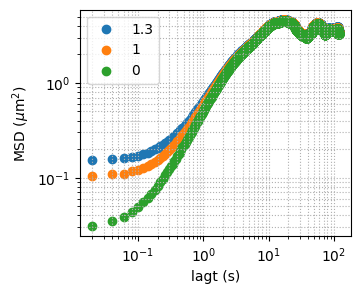

In [203]:
i = 175
logi = log.loc[log["DE#"]==i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# traj.y = gaussian_filter1d(traj.y, sigma=3/4)

plt.figure(figsize=(3.5, 3), dpi=100)
for noise in [1.3, 1, 0]:
    t = traj.copy()
    t.x += (2 * np.random.rand(len(t)) - 1) * noise
    t.y += (2 * np.random.rand(len(t)) - 1) * noise
    msd = tp.msd(t, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
    msd = msd.dropna()
    plt.scatter(msd.lagt, msd["<y^2>"], label=noise)

plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")
plt.legend()

### 2.1 Direct fitting

Let us try first to directly fit the MSD data using the 3-parameter Langevin model
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

In [32]:
def msd_model(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return dy2

t1=0.55 s, t2=0.55 s, DA=19.02 um^2/s


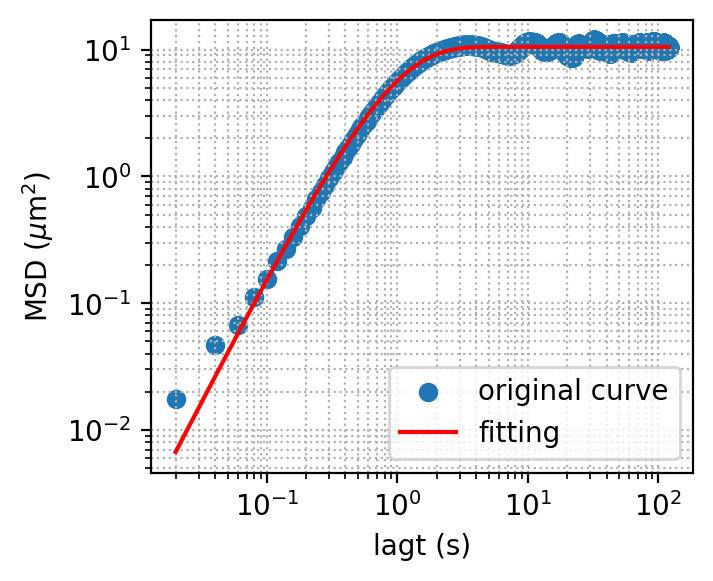

In [363]:
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), p0=[.4, 0.01, 1])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

### 2.2 Fit the log data

The MSD data span more than 3 orders of magnitude. When we fit directly by minimizing the least square, the small MSD regime does not fit well. This is because at small scale, even if the fitting deviates from data by 100%, the absolute square error is nothing compared to a small deviation at large scales. To make both small and large scale fitting important, we take a log of the MSD data to make the numbers to be fitted on the same order of magnitude. 

In [30]:
# try to fit log data
def msd_model_log(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

t1=0.56 s, t2=0.56 s, DA=18.57 um^2/s


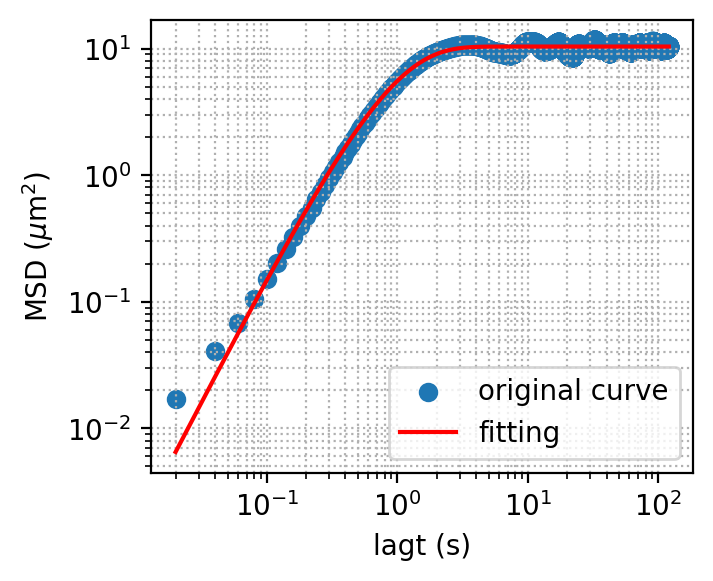

In [314]:
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), 
                       p0=[10, 0.1, 1])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

### 2.3 Simple 2-parameter model, fix $\tau=0.15$ s (deprecated)

$\tau = 0.15$ s is a characteristic time scale of bacterial dynamics, estimated from the length of bacteria $l_b\approx 3$ $\mu$m and the swimming speed of bacteria $v_b\approx 20$ $\mu$m/s:
$$
\tau = \frac{l_b}{v_b} = 0.15 \:\text{s}
$$
We also assume that $t\gg\tau$, so that $e^{-t/\tau}\to 0$. This leads to a simplified model with only two fitting parameters $D_A$ and $\tau^*$: (keeping the $e^{-t/\tau}$ term leads to difficulty in fitting)
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*}{1-(\tau/\tau^*)^2}
$$

In [223]:
def msd_model_simp(lagt, DA, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    tau = 0.15
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star) / (1 - (tau/tau_star)**2)
    return dy2

t2=3.56 s, DA=0.53 um^2/s


[]

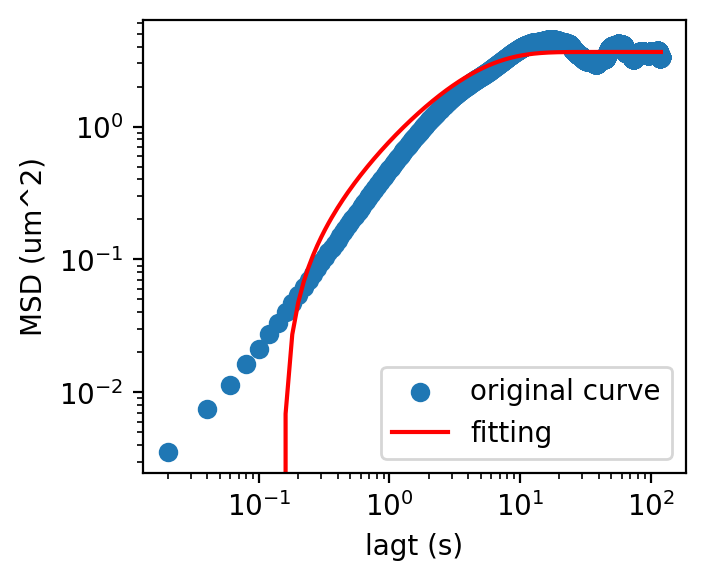

In [225]:
popt, pcov = curve_fit(msd_model_simp, new_msd.lagt, new_msd["<y^2>"], p0=[1, 5])
print("t2={1:.2f} s, DA={0:.2f} um^2/s".format(popt[0], popt[1]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model_simp(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD (um^2)")
plt.loglog()

<font color="blue">The fitting works pretty well for the long time limit. However, in the short time regime, due to our approximation, the fitting goes off. Now that we are able to get full trajectories, we deprecate this simple model fitting and switch to original model fitting.</font>

### 2.3 Fit all the MSD data and generate MSD fitting repo

Using the reduced model, we fit all the MSD curves and extract more accurate and unambiguous $D_A$ and $\tau^*$. To be able to check the fitting quality later, I save all the fitting plots in the MSD repo so I can come back at any time. 

<font color="red">The block below plots MSD fittings and save results as pictures in "Pictures" folder!</font>

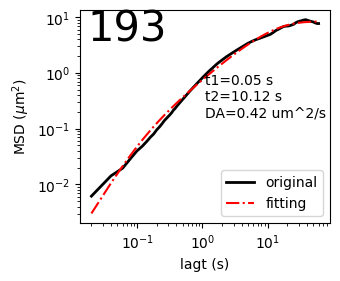

In [396]:
traj_folder = os.path.join(data_folder, "traj")
fig_folder = r"C:\Users\liuzy\Pictures"
log1 = log.loc[log.Comment!="Chile"]
count = 0
DE_list = [] # DE# list
DA_list = [] # container for fitted D_A values
tau_list = [] # container for fitted tau values
for num, i in log.iterrows():
    nDE = int(i["DE#"])
    if nDE <= 160 or nDE in suspicious_traj:
        continue
    if os.path.exists(os.path.join(traj_folder, "{:02d}.csv".format(i["DE#"]))) == False:
        continue
#     traj = pd.read_csv(os.path.join(traj_folder, "{:02d}.csv".format(i["DE#"])))
#     msd = tp.msd(traj, mpp=i.MPP, fps=i.FPS, max_lagtime=traj.frame.max()//5)
#     msd = msd.dropna()    
    msd = msd_list[nDE]
    
    x = msd.lagt.iloc[:10]
    y = msd["<y^2>"].iloc[:10]
    p = np.polyfit(x, y, 2)
    xfit = np.linspace(0, 0.2)
    yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
    offset = yfit[0]
    
    popt, pcov = curve_fit(msd_model_log, msd.lagt, np.log(msd["<y^2>"]-offset), p0=[4, .01, 5])

    fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
    ax.plot(msd.lagt, msd["<y^2>"]-offset, color="black", lw=2, label="original")
    ax.plot(msd.lagt, msd_model(msd.lagt, *popt), color="red", ls="-.",label="fitting")
    ax.legend(loc="lower right")
    ax.set_xlabel("lagt (s)")
    ax.set_ylabel("MSD ($\mu$m$^2$)")
    ax.annotate("{:d}".format(i["DE#"]), (.25, .8), xycoords="figure fraction", fontsize=30)
    ax.annotate("t1={0:.2f} s\nt2={1:.2f} s\nDA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]), 
                (.5, .5), xycoords="axes fraction", fontsize=10)
    ax.loglog()
    plt.tight_layout()
    plt.pause(0.01)
    fig.savefig(os.path.join(fig_folder, "{:d}.jpg".format(i["DE#"])))
    clear_output(wait=True)
    plt.close()
    count += 1
    if count > 10000:
        break

In [387]:
offset

0.14262754378383935

### 2.4 Compare hand fitting and automatic fitting

Hand fitting and automatic fitting both characterize the plateau transition time and plateau value of MSD curves. Here, we compare the results from the two fitting techniques. In hand fitting, we get $\tau^*$ and $R_\infty$, while in automatic fitting, we get $\tau^*_{fit}$ and $D_A$. The following is expected:
$$
\tau^* \approx \tau^*_{fit} \\
R_\infty^2 / \tau^* \approx D_A
$$
The comparison is shown below:

In [6]:
# filter out Chile data
log1 = log.loc[log.Comment!="Chile"]

(0.0, 200.0)

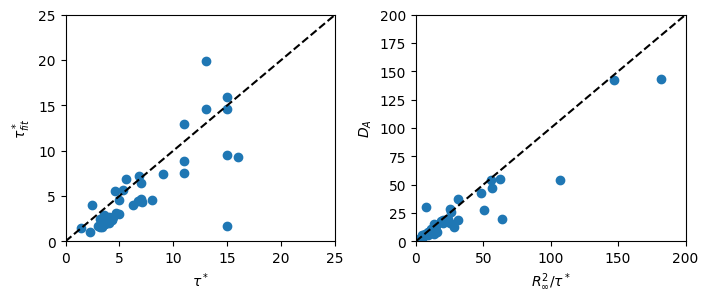

In [149]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3), dpi=100, gridspec_kw={"wspace": 0.3})
# compare \tau^* and \tau^*_{fit}
ax[0].scatter(log1.t2, log1.t2_fit)
ax[0].plot([0, 25], [0, 25], color="black", ls="--")
ax[0].set_xlim([0, 25])
ax[0].set_ylim([0, 25])
ax[0].set_xlabel("$\\tau^*$")
ax[0].set_ylabel("$\\tau^*_{fit}$")
# compare R_\infty^2/\tau^* and D_A
ax[1].scatter(log1.Rinfy/log1.t2, log1.DA_fit)
ax[1].plot([0, 200], [0, 200], color="black", ls="--")
ax[1].set_xlabel("$R_\infty^2/\\tau^*$")
ax[1].set_ylabel("$D_A$")
ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 200])

The two fitting techniques roughly give consistent results. However, a few outliers are identified and will be investigate in the next section. 

### 2.5 Look at the outliers

We first replot the comparison above and annotate DE# beside each data points.

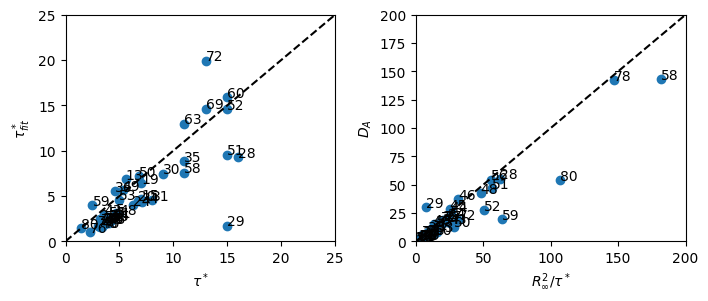

In [150]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3), dpi=100, gridspec_kw={"wspace": 0.3})
# compare \tau^* and \tau^*_{fit}
ax[0].scatter(log1.t2, log1.t2_fit)
ax[0].plot([0, 25], [0, 25], color="black", ls="--")
ax[0].set_xlim([0, 25])
ax[0].set_ylim([0, 25])
ax[0].set_xlabel("$\\tau^*$")
ax[0].set_ylabel("$\\tau^*_{fit}$")
for num, i in log1.iterrows():
    ax[0].annotate(i["DE#"], (i.t2, i.t2_fit))
# compare R_\infty^2/\tau^* and D_A
ax[1].scatter(log1.Rinfy/log1.t2, log1.DA_fit)
ax[1].plot([0, 200], [0, 200], color="black", ls="--")
ax[1].set_xlabel("$R_\infty^2/\\tau^*$")
ax[1].set_ylabel("$D_A$")
ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 200])
for num, i in log1.iterrows():
    ax[1].annotate(i["DE#"], (i.Rinfy/i.t2, i.DA_fit))

##### DE#29

In the left panel, the most outstanding outlier is DE#29. Let's look at its MSD and fitting in detail.

![](../images/2022/05/outlier1.png)

In the original MSD, since the displacement of DE#29 is much smaller than other ones in the same plot, the scale is quite small and therefore the linear diffusive regime is hard to identify. This leads to a big error when I tried to determine $\tau^*$ from the MSD collection plot. On the right, I show the automatic fitting result. The fitting looks good, since it captures both the plateau value and the transition time correctly. Hence, for this point, I trust the automatic fitting result, i.e. $\tau^*=1.7$ s. 

If we look at the $D_A$ vs. $R_\infty^2/\tau^*$ plot on the right, we find that DE#29 is also an outlier. However, if we use $\tau^*=1.7$ s, the automatic fitting result for the calculation of $R_\infty^2/\tau^*$, it turns out that $R_\infty^2/\tau^*\approx 58.8$ $\mu$m$^2$/s, within a factor of two difference with the fitted $D_A$ value $30$ $\mu$m$^2$/s. 

##### DE#72

DE#72 is also an outlier in the left panel. The original MSD curve and the fitting curve are shown below:

![](../images/2022/05/outlier2-72.png)

The MSD looks all fine, but due to the fact that inner droplet popped out during the video, the length of this trajectory is relatively short, resulting in the fitting curve to overestimate $\tau^*$.

Actually, if we increase the max lag time of MSD (from videolength/10 to videolength/5), the plateau regime of DE#72 MSD becomes more pronounced and the fitted $\tau^*$ gets smaller (9.9) and closer to the hand fitting $\tau^*$ (13):

![](../images/2022/05/longer-fitting-72.jpg)

Except DE#29 and DE#72, all other results from two fitting techniques remain close to each other and follow the same trend. Since the automatic fitting provides more accuracy and less ambiguity, we switch from now on the down stream analysis to automatic fitting. 

### 2.6 Try $D_A$ vs. $D-d$

We have seen the plot of $R_\infty^2/\tau^*$ vs. $D-d$, and saw an increasing trend roughly. Dispite the increasing trend, the data looks quite scattered, even on log-log scale. I suspect that the scattering is due to the inaccuracy of hand fitting of $R_\infty$ and $\tau^*$. That is the reason why I go for the model automatic fitting here. Supposedly, this fitting has better accuracy. Let's plot the equivalence of $R_\infty^2/\tau^*$ vs. $D-d$, i.e. $D_A$ vs. $D-d$, to verify this geometry-dependent active noise. 

We have already noticed that active noise depends strongly on $OD$. Therefore, this plot only include $OD\in[60, 80]$, in order to reveal a clear relationship.

Text(0, 0.5, '$D_A$ ($\\mu$m$^2$/s)')

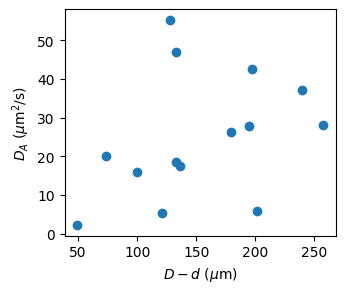

In [7]:
log2 = log1.loc[(log1.OD>=60)&(log1.OD<=80)]
log2 = log2.loc[~np.isnan(log2.t2)]
plt.figure(figsize=(3.5, 3), dpi=100)
plt.scatter(log2.D, log2.DA_fit)
# for num, i in log2.iterrows():
#     plt.annotate(i["d"], (i.D-i.d, i.DA_fit))
# plt.loglog()
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("$D_A$ ($\mu$m$^2$/s)")
# plt.xlim([0, 225])
# plt.ylim([0, 60])

This is again, more of scattered data than an increasing trend. To understand this data, we annotate the corresponding inner droplet diameter beside each data points:

![](../images/2022/05/DA_D-d.png)

The data show a segregation by inner droplet size $d$. For small $d$, $D_A$ is larger; for large $d$, $D_A$ is smaller. This is intuitive since we always observe that, when other conditions are fixed, smaller inner droplets show stronger fluctuations. If we look at a narrow range of $d$, say the *middle* range where $d\approx 25$ $\mu$m, we can fit a linear relation between $D_A$ and $D-d$. The slope $\approx 0.2$ $\mu$m/s is a velocity, while the physical significance is unclear. 

### 2.7 Fitting only the short time regime

The 3-parameter fitting in section 2.1 worked fine at long time limit. However, it does not provide an accurate account for the short time scale, where particle dynamics transition from ballistic to diffusive (theoretically). Here, we take closer look at the short time limit of MSD data (unsmoothed). Let's see if we can have more accurate fitting of $\tau$ by only fitting short time regime. 

The model we are going to fit data to is:
$$
\langle \Delta y^2 \rangle = \frac{D_A}{\tau(1+\tau/\tau^*)}t^2
$$
assuming $\tau^*\gg\tau$, 

## 3 Relaxation time $\tau^*$

The spring model predicts the relaxation time $\tau^*$ as:
$$
\tau^* = \frac{9\eta}{\Delta\rho g}\frac{D-d}{d^2}
$$
This should be the first thing to check after fitting MSD for $t_2$.

(0.0, 22.0)

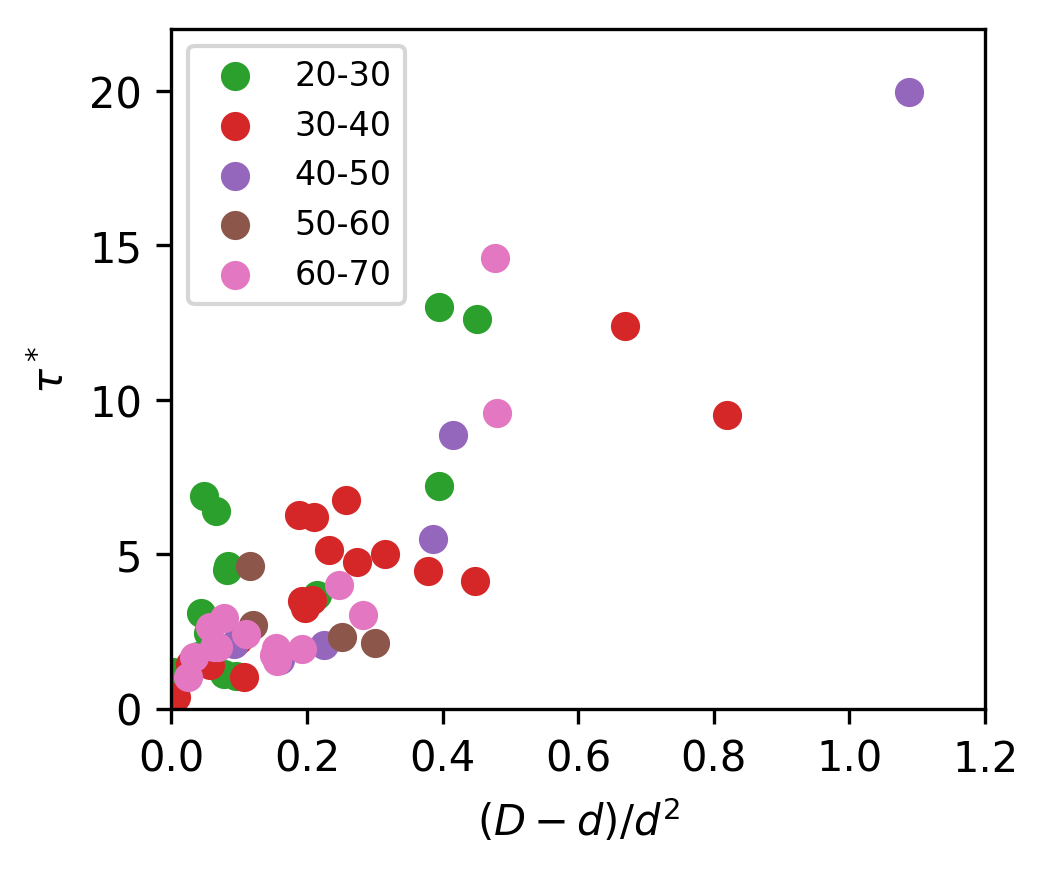

In [3]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)]
dd1 = de_data(log1)
dd1.scatter(x="(D-d)/d^2", y="t2_fit", xlabel="$(D-d)/d^2$", ylabel="$\\tau^*$", mode="lin")
plt.legend(loc="upper left", fontsize=8)
plt.xlim([0, 1.2])
plt.ylim([0, 22])

(0.0, 10.0)

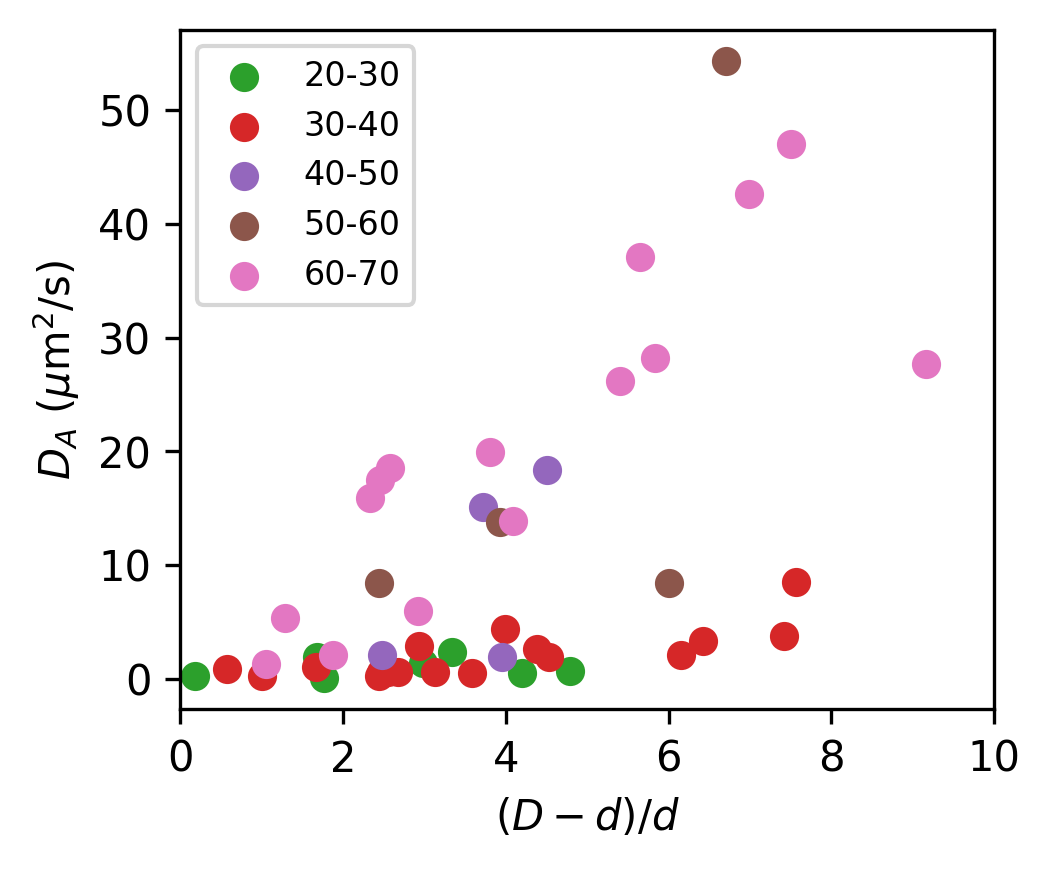

In [13]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)]
dd1 = de_data(log1)
dd1.scatter(x="(D-d)/d", y="DA_fit", xlabel="$(D-d)/d$", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="lin")
plt.legend(loc="upper left", fontsize=8)
plt.xlim([0, 10])

With new OD 20-40 data added, the linear relation becomes much more convincing.

The $\tau^*$ result above shows good linear dependence on $(D-d)/d^2$. This has inspired us to use theoretical $\tau^*$ as a given constant and fit for $\tau$ and $D_A$. <font color="blue">To be done</font>

## 4 1-D projection in a sphere

We use the solution of the Langevin equation in Maggi et al. 2014 (MSD) to fit our data. Although the fitting look okay, we need to stress a difference between our experimental geometries, being that their confinement is a cylinder and our confinement is a sphere, which can lead to different solutions. The following sketch shows the different geometries. 

![](../images/2022/05/sphere-cylinder-diff.png)

For their cylindrical system, the Langevin equation is written as 
$$
\mathbf{\dot r} = \mu \mathbf{f(r)} + \mathbf{\eta^A} + \mathbf{\eta^T},
$$
where $\mathbf{f(r)}=(0, -ky)$, basically no restoring force along the flat direction and an approximated spring force along the curved direction. Therefore, they can solve only the $y$-component equation to get $\langle \Delta y^2(t) \rangle$. The solution is the one we have always been using:
$$
\langle \Delta y^2(t) \rangle = \frac{2D_A}{\mu k}\frac{1-e^{-\mu k t} - \mu k\tau (1-e^{-t/\tau})}{1-(\mu k\tau)^2}
$$

We can also decompose the vectors in spherical coordinates:
$$
\dot r = \mu f(r) + \eta^A_r + \eta^T_r \\
r\dot\theta = \eta^A_\theta + \eta^T_\theta
$$

The r-component equation can be solved for $\langle \Delta r^2(t) \rangle$. But I'm not sure if I write the $\theta$-component equation right. 

For our spherical system, the original equation has to be modified. Specifically, the restoring force $\mathbf{f(r)}$ depends on both $x$ and $y$ position. Essentially, $\mathbf{f(r)}$ is now isotropic in $xy$-plane, formally $f(r) = kr$, so we can write the Langevin equation as:
$$
\dot r = -\mu k r + \eta^A + \eta^T
$$
where $r = \sqrt{x^2+y^2}$. 

We notice that this is almost identical to the $y$-component equation in the cylindrical system, <font color="red">except that the noise magnitude should be twice since we consider two spacial dimensions.</font> The solution is therefore identical in the form, except the prefactor:
$$
\langle \Delta r^2(t) \rangle = \frac{4D_A}{\mu k}\frac{1-e^{-\mu k t} - \mu k\tau (1-e^{-t/\tau})}{1-(\mu k\tau)^2}.
$$

What we observe with confocal is not $\langle \Delta r^2(t) \rangle$, but $\langle \Delta y^2(t) \rangle$. Due to the isotropic nature of the motion, we can connect $\langle \Delta r^2(t) \rangle$ and $\langle \Delta y^2(t) \rangle$ by:
$$
\Delta y(t) = \Delta r(t)\cos\theta,
$$
where $\theta$ is the angle between $\Delta r$ and $y$-axis. It follows:
$$
\langle \Delta y^2(t) \rangle = \langle \Delta r^2(t) \rangle \langle \cos^2\theta\rangle.
$$

Hence, $\langle \Delta y^2(t) \rangle$ and $\langle \Delta r^2(t) \rangle$ take exactly the same form, only has a difference in the prefactor $\langle \cos^2 \theta \rangle=\int_0^{2\pi}P(\theta)\cos^2\theta \,d\theta=\frac{1}{2}$. Interestingly, with this prefactor evaluated, we go back to exactly the same $\langle \Delta y^2(t) \rangle$ as in the cylindrical system. 

## 5 Rescaling $D_A$ data and outliers

In the May 12th meeting, we found a good collapse of $D_A$ data by normalizing $D-d$ with $d$ for the $OD\in[60, 80]$ bracket. I plot below the original $D_A$ vs. $D-d$ plot, along with the plot where $D-d$ is rescaled by $d$.

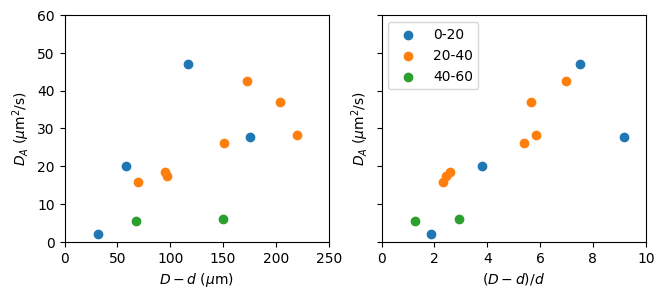

In [79]:
log2 = log1.loc[(log1.OD>=60)&(log1.OD<=80)]
log2 = log2.loc[~np.isnan(log2.t2)]
bounds = [[0, 20], [20, 40], [40, 60]]
colors = [bestcolor(0), bestcolor(1), bestcolor(2)]

fig, ax = plt.subplots(ncols=2, figsize=(7.5, 3), dpi=100, sharey=True)

for bound, color in zip(bounds, colors):
    log3 = log2.loc[(log2.d>=bound[0])&(log2.d<bound[1])]
    ax[0].scatter(log3.D - log3.d, log3.DA_fit, color=color)
ax[0].set_xlabel("$D-d$ ($\mu$m)")
ax[0].set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax[0].set_xlim([0, 250])
ax[0].set_ylim([0, 60])

for bound, color in zip(bounds, colors):
    log3 = log2.loc[(log2.d>=bound[0])&(log2.d<bound[1])]
    ax[1].scatter((log3.D - log3.d)/log3.d, log3.DA_fit, color=color, label="{0:d}-{1:d}".format(bound[0], bound[1]))
ax[1].set_xlabel("$(D-d)/d$")
ax[1].set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax[1].set_xlim([0, 10])
ax[1].set_ylim([0, 60])
ax[1].legend()

In the rescaled data, all the points follow a nice linear relation, except a blue point at (9, 25), corresponding to DE#52. Looking at the video (1103/06), the bacterial activity is indeed lower than expected. Therefore, it makes sense that the $D_A$ in this experiment deviates from the "normal" linear relation.

With this $OD$ bracket fixed, let's extend this rescaling to all the data and see how is the collapse.

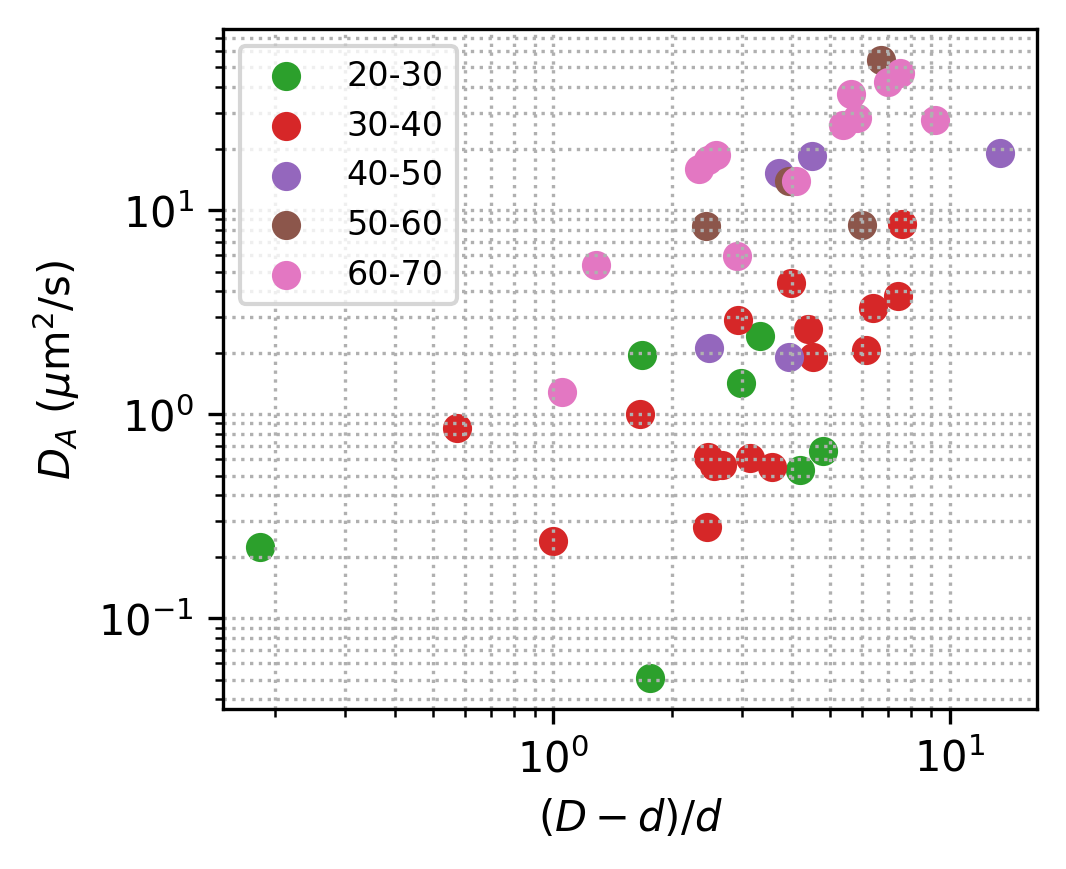

In [151]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)&(log["DE#"]>24)]
dd1 = de_data(log1)
ax = dd1.scatter(x="(D-d)/d", y="DA_fit", xlabel="$(D-d)/d$", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log")
log2 = log.loc[log["DE#"]<23]
ax.legend(loc="upper left", fontsize=8)
# ax.scatter(log2["(D-d)/d"], log2["DA_fit"], color=bestcolor(1), marker="^", fc=(0,0,0,0))
# ax.set_xlim([0, 10])
# ax.set_ylim([0, 60])

### 5.1 Limit cases

An intuitive limit case to test is $D\to \infty$. Practically, we can study the diffusion of oil droplets near a flat glass surface, agitated by active bacterial bath. Such unconfined motion will likely give a superdiffusive-diffusive type of MSD, and can be fitted using Wu and Libchaber's model for a diffusivity $D_A$. Such $D_A$, according to the current trend, should be the upper bound of the corresponding $D_A$'s confined in curved spaces. 

<font color="blue">An experiment of oil droplets near a flat glass surface is needed!</font>

### 5.2 Concentration dependence

From the $D_A$ vs. $(D-d)/d$ plot, we can see a pronounced concentration dependence of $D_A$: low concentration points are below the high concentration points! What is the exact nature of this dependence? Let's choose a small range of $(D-d)/d$, and plot $D_A$ as a function of OD.

(0.0, 30.0)

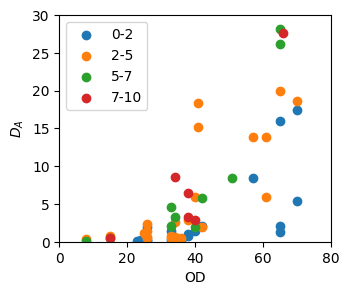

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 3),dpi=100)
d_bins = np.linspace(0, 10, 5)
binsize = d_bins[1] - d_bins[0]
for start in d_bins[:-1]:
    end = start + binsize
    sublog = log1.loc[(log["(D-d)/d"]>=start)&(log["(D-d)/d"]<end)]
    ax.scatter(sublog.OD, sublog.DA_fit, label="{0:d}-{1:d}".format(int(start), int(end)))
ax.legend()
ax.set_xlabel("OD")
ax.set_ylabel("$D_A$")
ax.set_xlim([0, 80])
ax.set_ylim([0, 30])
# ax.loglog()

## 6 Integrate data from literature

There are a few earlier works trying to measure the active diffusivity (or effective diffusivity). In Wu 2000, they fit the 2-D MSD with
$$
\langle\Delta\vec{r}^2(t)\rangle = 4Dt[1-\exp(-t/t_C)]
$$

In Maggi 2014, they fit 1-D MSD in the unconstrained direction $x$ with
$$
\langle\Delta x^2(t)\rangle = 2D_Tt + 2D_A[t-\tau(1-e^{-t/\tau})].
$$
In the $t\ll\tau$ limit, $1-e^{-t/\tau}\approx t/\tau - t^2/2\tau^2$, so that
$$
\langle\Delta x^2(t)\rangle = 2D_Tt + 2D_A[t-\tau(t/\tau - t^2/2\tau^2)] = 2D_Tt + \frac{D_A}{\tau}t^2
$$

In the diffusive regime, where $t\gg\tau$, the first expression simplifies to
$$
\langle\Delta\vec{r}^2(t)\rangle = 4Dt,
$$
while the second expression simplifies to
$$
\langle\Delta x^2(t)\rangle = 2(D_T+D_A)t.
$$

Note that the prefactor difference comes from the 2-D and 1-D difference. Then we realize that $D_{\text{eff}}$ is equivalent to $D_A+D_T$. If $D_T\ll D_A$, which is usually the case for particles larger than 10 $\mu$m, $D_{\text{eff}}$ is equivalent to $D_A$.

**Aside: diffusivity of 10 $\mu$m particle**

According to Stokes-Einstein relation, the diffusivity of a 10 $\mu$m particle in water is 
$$
D = \frac{k_BT}{6\pi\eta R} = \frac{1.38\times 10^{-23} \times 300}{6\pi \times 0.001 \times 5 \times 10^{-6}} = 0.04\,\mu\text{m}^2/\text{s}
$$

In [24]:
1.38e-23 * 300 / (6*np.pi*0.001*0.5e-5) * 1e12

0.04392676429336311

while the active diffusivity $D_A$ is typically greater than 0.1 $\mu$m$^2$/s. Therefor,e $D_A\gg D_T$ is true for most scenarios we are concerned.

### 6.1 Literature list

1. Wu, Xiao-Lun, and Albert Libchaber. “Particle Diffusion in a Quasi-Two-Dimensional Bacterial Bath.” Physical Review Letters 84, no. 13 (March 27, 2000): 3017–20. https://doi.org/10.1103/PhysRevLett.84.3017.
2. Miño, Gastón, Thomas E. Mallouk, Thierry Darnige, Mauricio Hoyos, Jeremi Dauchet, Jocelyn Dunstan, Rodrigo Soto, Yang Wang, Annie Rousselet, and Eric Clement. “Enhanced Diffusion Due to Active Swimmers at a Solid Surface.” Physical Review Letters 106, no. 4 (January 25, 2011): 048102. https://doi.org/10.1103/PhysRevLett.106.048102.
3. Kasyap, T. V., Donald L. Koch, and Mingming Wu. “Hydrodynamic Tracer Diffusion in Suspensions of Swimming Bacteria.” Physics of Fluids 26, no. 8 (August 2014): 081901. https://doi.org/10.1063/1.4891570.
4. Patteson, Alison E., Arvind Gopinath, Prashant K. Purohit, and Paulo E. Arratia. “Particle Diffusion in Active Fluids Is Non-Monotonic in Size.” Soft Matter 12, no. 8 (2016): 2365–72. https://doi.org/10.1039/C5SM02800K.
5. Lagarde, Antoine, Noémie Dagès, Takahiro Nemoto, Vincent Démery, Denis Bartolo, and Thomas Gibaud. “Colloidal Transport in Bacteria Suspensions: From Bacteria Collision to Anomalous and Enhanced Diffusion.” Soft Matter 16, no. 32 (August 19, 2020): 7503–12. https://doi.org/10.1039/D0SM00309C.
6. Maggi, Claudio, Matteo Paoluzzi, Nicola Pellicciotta, Alessia Lepore, Luca Angelani, and Roberto Di Leonardo. “Generalized Energy Equipartition in Harmonic Oscillators Driven by Active Baths.” Physical Review Letters 113, no. 23 (December 3, 2014): 238303. https://doi.org/10.1103/PhysRevLett.113.238303.

### 6.2 Diffusivity of particles in bacterial suspensions (literature)

The diffusivity of passive particles, which reflects the effective temperature of an active bath, has been studied extensively. Many factors have been varied to elucidate the nature of active noise, e.g. OD, particle size, particle density, as well as boundary conditions. Here, we summarize the $D_{\text{eff}}$ data from literature to so we can make more detailed comparison with our data. 

In [50]:
D_data = pd.read_excel(io=r"..\Data\diffusivity_literature.ods")
D_data.head()

,Bacterial concentration,OD,Tracer size,Curvature radius,Effective diffusivity,Thermal diffusivity,D_T/D_eff,Experimental system,Tracer material,Deff/OD*Tracersize,Reference,Comment
0,3000000000,3.750,10.0,0,10.0,0.043949,0.004395,Free-standing film,PS,26.666667,Wu 2000,NaN
1,6700000000,8.375,10.0,0,15.0,0.043949,0.002930,Free-standing film,PS,17.910448,Wu 2000,NaN
2,13400000000,16.750,10.0,0,35.0,0.043949,0.001256,Free-standing film,PS,20.895522,Wu 2000,NaN
3,26000000000,32.500,10.0,0,65.0,0.043949,0.000676,Free-standing film,PS,20,Wu 2000,NaN
4,53500000000,66.875,10.0,0,100.0,0.043949,0.000439,Free-standing film,PS,14.953271,Wu 2000,NaN


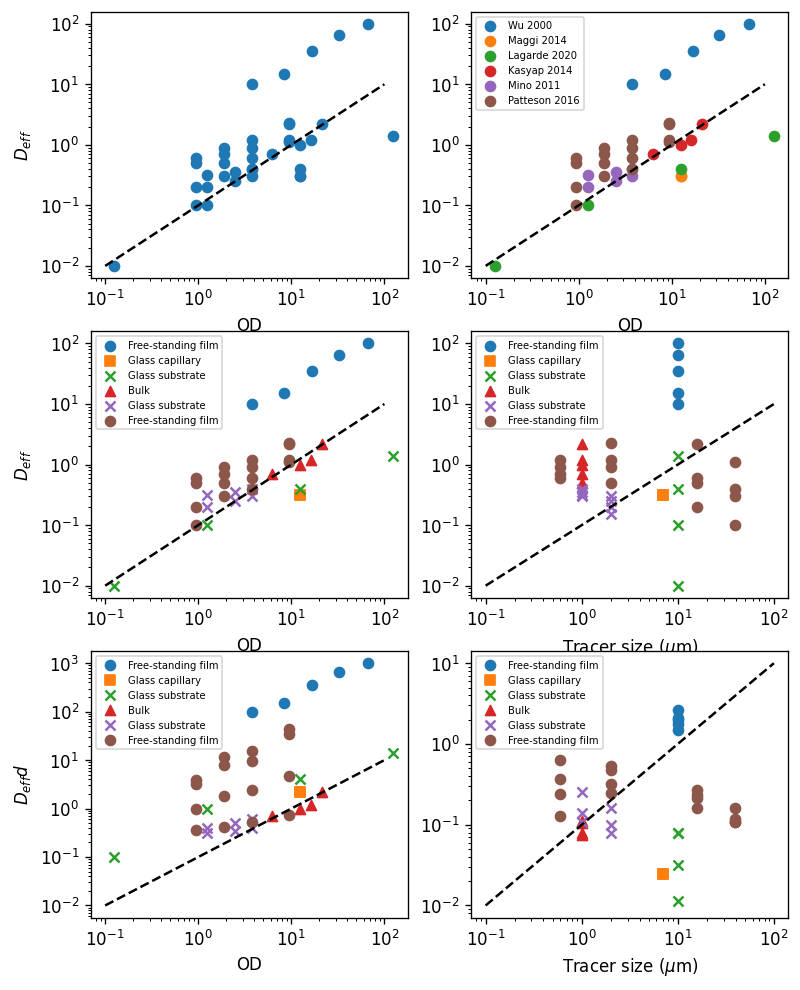

In [89]:
fig = plt.figure(figsize=(7.5, 10), dpi=120)
ax = fig.add_subplot(321)
ax.scatter(D_data.OD, D_data["Effective diffusivity"])
ax.loglog()
ax.set_xlabel("OD")
ax.set_ylabel(r"$D_{eff}$")
ax.plot([.1, 100], [.01, 10], ls="--", color="black")

# discern data from different works
ax1 = fig.add_subplot(322)
for num, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num)
    subdata = D_data.loc[D_data["Reference"]==ref]
    ax1.scatter(subdata.OD, subdata["Effective diffusivity"], label=ref, color=color)
ax1.loglog()
ax1.set_xlabel("OD")
ax1.plot([.1, 100], [.01, 10], ls="--", color="black")
ax1.legend(fontsize=6)

# discern data of different boundary condition
ax2 = fig.add_subplot(323)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax2.scatter(subdata.OD, subdata1["Effective diffusivity"], label=es, color=color, marker=marker)
ax2.loglog()
ax2.set_xlabel("OD")
ax2.set_ylabel(r"$D_{eff}$")
ax2.plot([.1, 100], [.01, 10], ls="--", color="black")
ax2.legend(fontsize=6)

# plot as a function of particle size
ax3 = fig.add_subplot(324)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax3.scatter(subdata["Tracer size"], subdata1["Effective diffusivity"], label=es, color=color, marker=marker)
ax3.loglog()
ax3.set_xlabel("Tracer size ($\mu$m)")
ax3.plot([.1, 100], [.01, 10], ls="--", color="black")
ax3.legend(fontsize=6)

# Rescale D_eff by timing tracer size, plot vs. OD
ax4 = fig.add_subplot(325)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax4.scatter(subdata.OD, subdata1["Effective diffusivity"]*subdata1["Tracer size"], label=es, color=color, marker=marker)
ax4.loglog()
ax4.set_xlabel("OD")
ax4.set_ylabel(r"$D_{eff}d$")
ax4.plot([.1, 100], [.01, 10], ls="--", color="black")
ax4.legend(fontsize=6)

# Rescale D_eff by timing tracer size, plot vs. tracer size
ax5 = fig.add_subplot(326)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax5.scatter(subdata["Tracer size"], subdata1["Effective diffusivity"]/subdata1["OD"], label=es, color=color, marker=marker)
ax5.loglog()
ax5.set_xlabel("Tracer size ($\mu$m)")
ax5.plot([.1, 100], [.01, 10], ls="--", color="black")
ax5.legend(fontsize=6)

## 7 Pendulum-like at high bacterial concentration?

At high bacterial concentration, collective motion takes place. The inner droplet agitated by collectively moving bacteria exhibits a pendulum-like motion, which is qualitatively different from a noise-driven motion. Such pendulum-like motion is characterized by **high probability of finding the droplet at high potential positions**, as well as a **non-diffusive position autocorrelation**. Here, we analyze these two properties of the inner droplet trajectories and see if the two characteristics mentioned above really exists in our system. 

In [179]:
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
n = 176
traj = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(n)).fillna(method="bfill")
log_item = log.loc[log["DE#"]==n]
MPP = float(log_item.MPP)
FPS = float(log_item.FPS)

corr_time = 13.0
sigma = 2.9


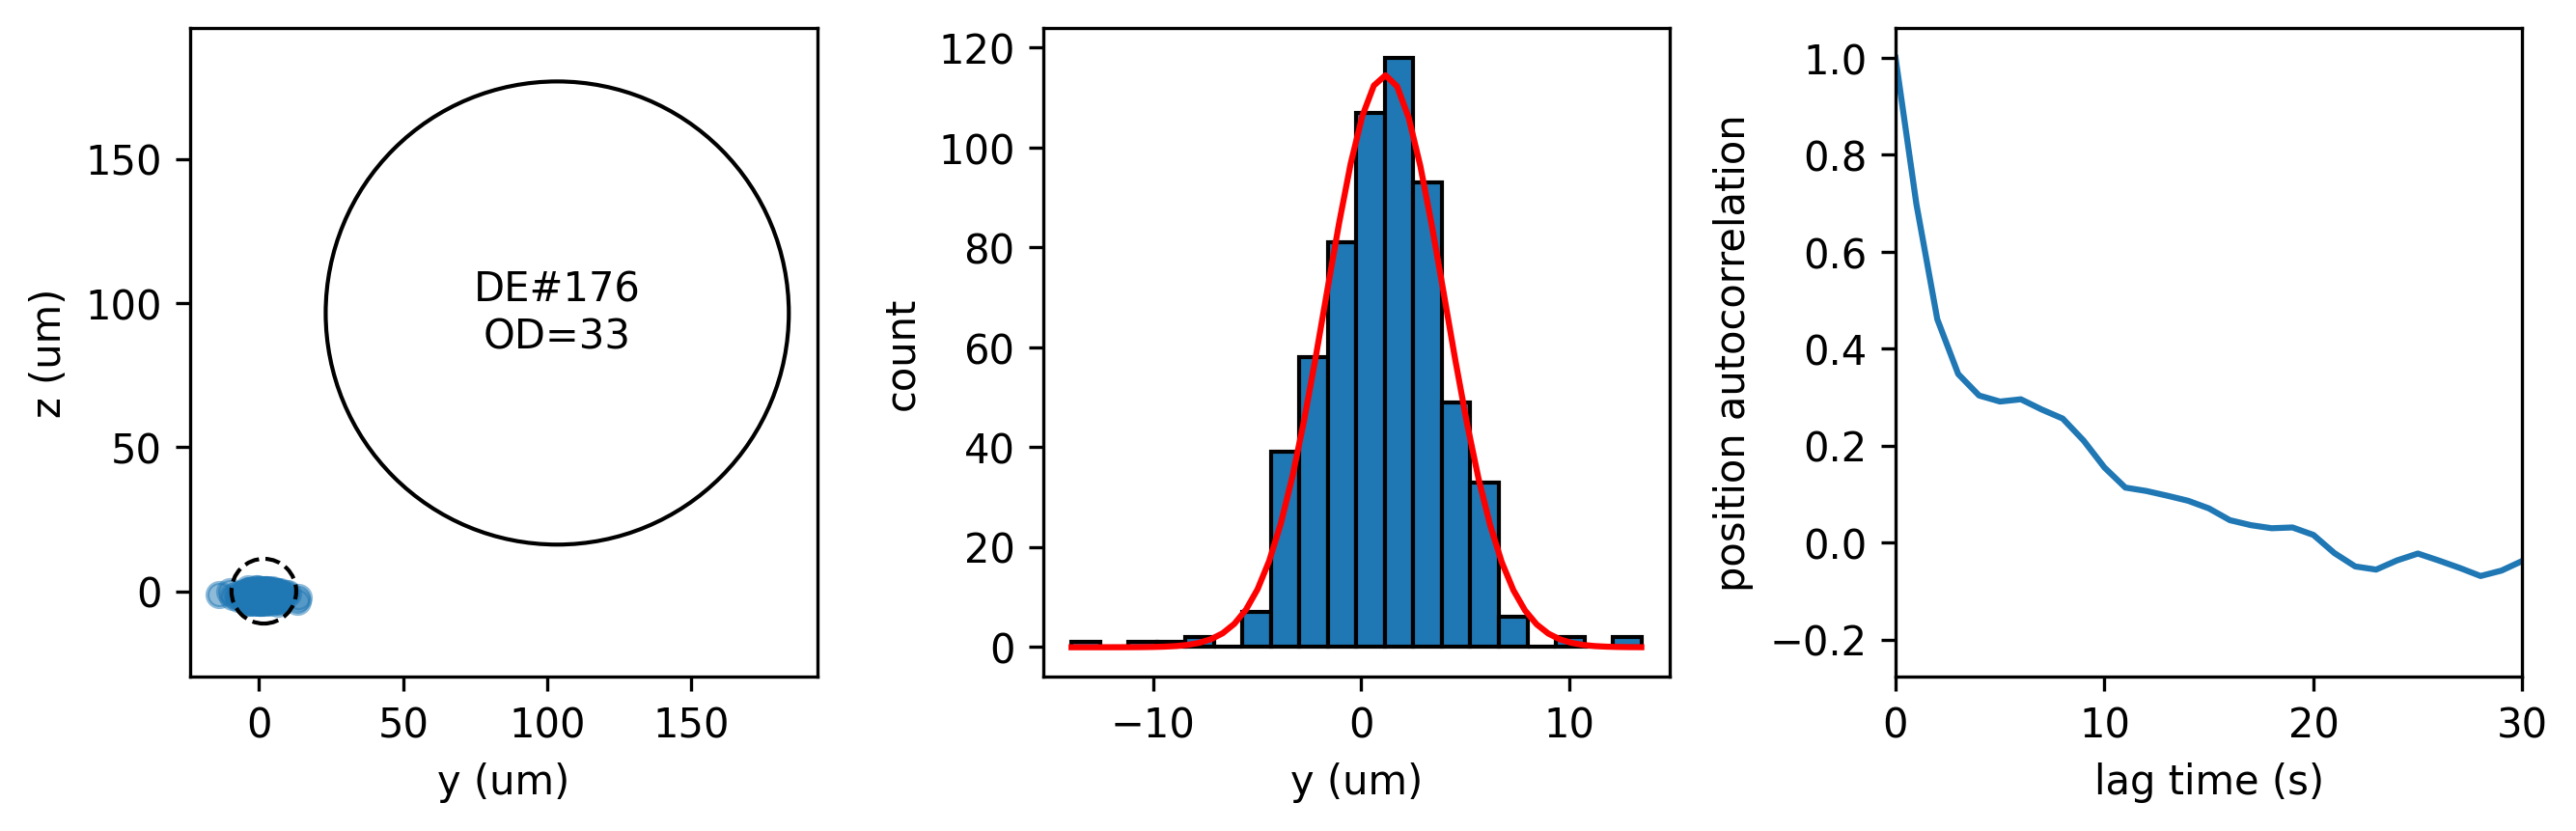

In [180]:
fig = plt.figure(figsize=(9, 3), dpi=300)
ax = fig.add_subplot(131)
ax.scatter(traj.y*MPP, traj.x*MPP, alpha=0.5)
elli = Ellipse((log_item.y0*log_item.MPP, log_item.x0*MPP), log_item.D, log_item.D, facecolor=(0,0,0,0), edgecolor="black")
elli_inner = Ellipse((traj.y.iloc[0]*MPP, traj.x.iloc[0]*MPP), log_item.d, log_item.d, facecolor=(0,0,0,0), edgecolor="black", ls="--")
ax.add_patch(elli)
ax.add_patch(elli_inner)
ax.axis("equal")
ax.set_xlabel("y (um)")
ax.set_ylabel("z (um)")

ax.annotate("DE#{0:02d}\nOD={1:d}".format(n, int(log_item.OD)), (log_item.y0*log_item.MPP, log_item.x0*MPP), 
            horizontalalignment="center", verticalalignment="center")

# Position probability distribution
hist, bin_edges = np.histogram(traj.y.dropna()*MPP, bins=20)
ax2 = fig.add_subplot(132, sketch_params={"scale": 1, "length": 10, "randomness": 1})
ax2.bar((bin_edges[:-1]+bin_edges[1:])/2, hist, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax2.set_ylabel("count")
ax2.set_xlabel("y (um)")

## Fit a Gaussian to the position distribution
x = np.linspace(bin_edges[0], bin_edges[-1])
popt, pcov = curve_fit(gauss1, (bin_edges[:-1]+bin_edges[1:])/2, hist, 
                       p0=[hist.mean(), bin_edges.mean(), bin_edges[-1]-bin_edges[0], 0])
ax2.plot(x, gauss1(x, *popt), color="red")

# Position autocorrelation
corr = autocorr1d(traj.y)
lagt = 1 / FPS * traj.frame[:len(corr)]
ax3 = fig.add_subplot(133)
ax3.plot(lagt, corr)
ax3.set_xlabel("lag time (s)")
ax3.set_ylabel("position autocorrelation")
ax3.set_xlim([0, 30])

plt.tight_layout()

print("corr_time = {:.1f}".format(lagt[find_zero(corr-1e-1)]))
print("sigma = {:.1f}".format(abs(popt[2])))


In [85]:
def find_zero(x):
    tmp = x > 0
    inds = np.where(tmp==False)
    return inds[0][0]

(0.0, 20.0)

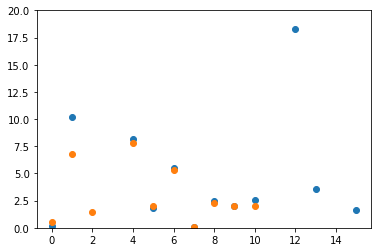

In [192]:
tmp_data = pd.read_excel(r"..\Data\structured_log_DE.ods", sheet_name="tmp")
plt.scatter(tmp_data.index, tmp_data.t2_new*tmp_data.DA_new)
plt.scatter(tmp_data.index, tmp_data.position_dist_sigma**2)

plt.ylim([0, 20])

In [148]:
tmp = corr > 0
inds = np.where(tmp==False)

In [154]:
lagt

0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
       ...  
295    295.0
296    296.0
297    297.0
298    298.0
299    299.0
Name: frame, Length: 300, dtype: float64

In [54]:
xn = x - np.nanmean(x)

In [56]:
np.correlate(xn, xn, mode="same")

array([nan, nan, nan, ..., nan, nan, nan])

Text(0, 0.5, 'angle (rad)')

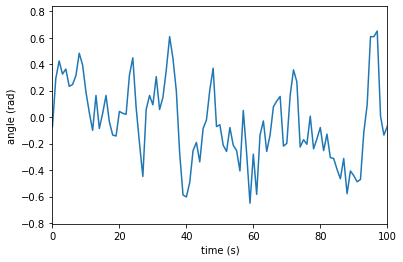

In [232]:
plt.plot(np.arctan((traj.y - float(log_item.y0))/float(log_item["D-d"])))
plt.xlim([0, 100])
plt.xlabel("time (s)")
plt.ylabel("angle (rad)")

(0.0, 50.0)

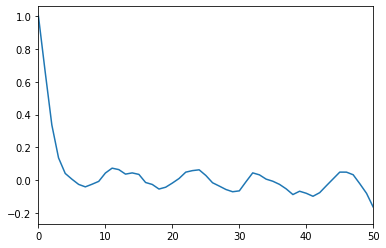

In [231]:
angle = np.arctan((traj.y - float(log_item.y0))/float(log_item["D-d"]))
corr = autocorr1d(angle)
plt.plot(corr)
plt.xlim([0, 50])

### 7.1 Hypothesis: constant speed circular motion
![](../images/2022/06/circular-motion.png)
$$
x = r\cos\omega t\\
y = r\sin\omega t\\
$$

If we look at the $y$-projection of the trajectory in one period:

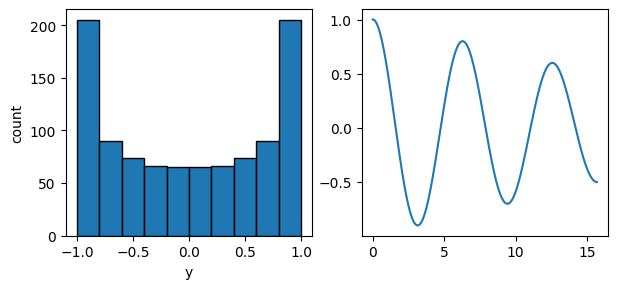

In [191]:
w = 1
r = 1
t = np.linspace(0, 10*np.pi/w, 1000)
y = r * np.sin(w*t)

hist, bin_edges = np.histogram(y)
fig= plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(121)
ax.bar((bin_edges[:-1]+bin_edges[1:])/2, hist, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax.set_xlabel("y")
ax.set_ylabel("count")

ax2 = fig.add_subplot(122)
corr = autocorr1d(y)
ax2.plot(t[:len(corr)], corr)

This circular motion has a very extreme bimodal position distribution. Actually, we saw this circular motion in the $xy$-plane very early on in experiment, and I made the best 3-D trajectory visualization out of that experiment. 

![rvref](../images/outer-ref-demo.gif)

The corresponding position distribution:

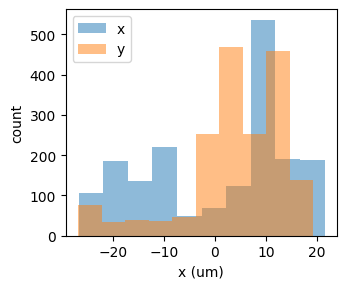

In [209]:
traj = pd.read_csv(r"..\Data\traj\01.csv")
MPP = 0.1
xhist, xbin_edges = np.histogram((traj.x-518)*MPP)
yhist, ybin_edges = np.histogram((traj.y-514)*MPP)

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
ax.bar((xbin_edges[:-1]+xbin_edges[1:])/2, xhist, width=xbin_edges[1]-xbin_edges[0],  alpha=0.5, label="x")
ax.bar((ybin_edges[:-1]+ybin_edges[1:])/2, yhist, width=ybin_edges[1]-ybin_edges[0],  alpha=0.5, label="y")
ax.set_xlabel("x (um)")
ax.set_ylabel("count")
ax.legend()

## 9 Small displacement approximation validation

The spring model assumes that the displacement of inner droplet is small compared to the outer droplet size, so that the restoring force is approximately proportional to the displacement in $y$. As we have estimated before, when the displacement goes beyond $r/2$ from equilibrium position, this approximation gets inaccurate. In practice, we want all the trajectory we analyze stay mostly in this range. Therefore, we compute the standard deviation y-displacement $\sigma_y$, and set a criterion $3\sigma_y < (R-r)$ to determine if we use the data in further analysis.

In [74]:
data_folder = r"..\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
c_list = []
for num, i in log.iterrows():
    traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i["DE#"])))
    c = 3 * traj.y.std() * i.MPP / (i.D - i.d) * 2
    c_list.append(c)

In [75]:
log1 = log.assign(c=c_list)

In [76]:
log1.to_csv("tmpc.csv")

## 11 Influence of mean velocity

In [38]:
log1 = log.dropna(subset=["mean velocity (1s)"])

In [42]:
log1 = log1.drop(labels=133)

Text(0, 0.5, 'mean velocity ($\\mu$m/s)')

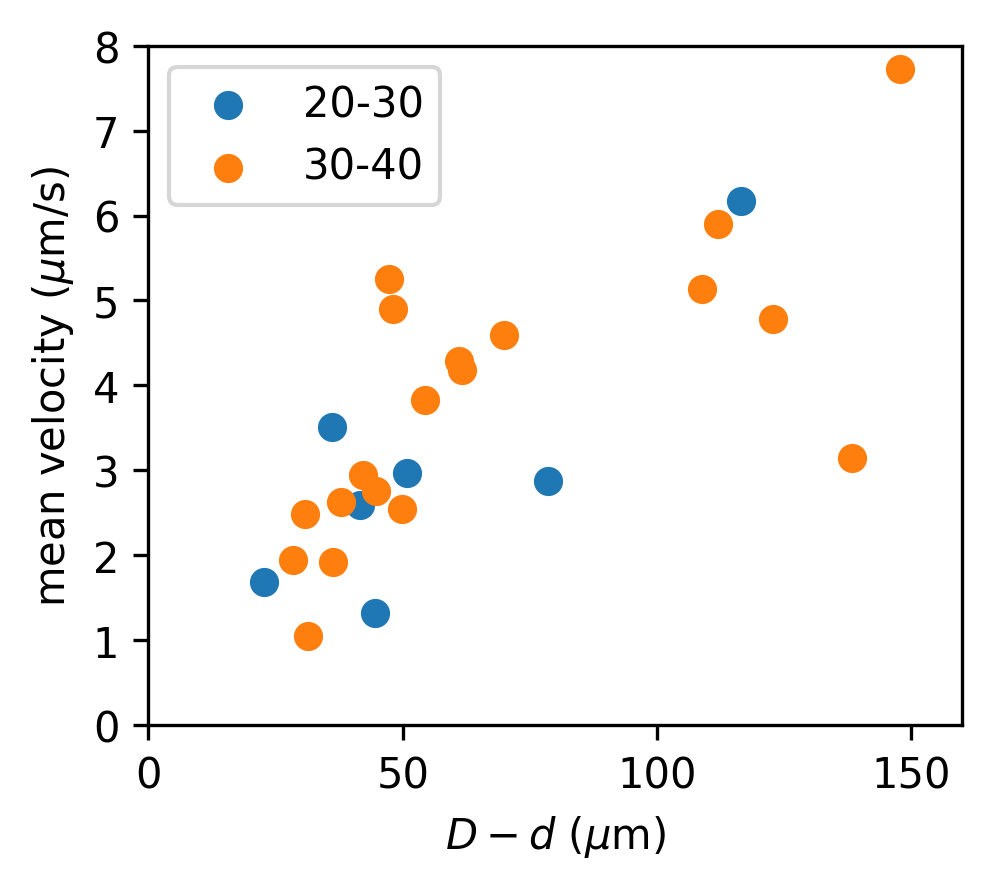

In [45]:
plt.figure(figsize=(3.5, 3), dpi=300)
log2 = log1.loc[log1.OD <= 30]
log3 = log1.loc[log1.OD > 30]
plt.scatter(log2["D-d"], log2["mean velocity (1s)"], label="20-30")
plt.scatter(log3["D-d"], log3["mean velocity (1s)"], label="30-40")
plt.legend()
plt.xlim([0, 160])
plt.ylim([0, 8])
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("mean velocity ($\mu$m/s)")

### To be discussed
1. 1-D projection MSD
2. Tracer size dependence (inner droplet)
3. Curvature dependence and collective motion 